# 聚合的层次聚类（数据预处理中作LDA降维）

## 一、库导入

In [2]:
import scipy
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score
from sklearn.decomposition import PCA

from seaborn import pairplot

from pylab import rcParams

## 二、全局参数设置

In [3]:
mpl.rcParams['figure.dpi']= 300 # 设置图片分辨率
np.set_printoptions(precision=4, suppress=True) # 设置浮点精度(小数点后四位)
plt.figure(figsize=(30,10)) # 设置图片大小
# 使用jupyter notebook时可直接在python console里生成图像
%matplotlib inline
plt.style.use('seaborn') # 设置图片样式

## 三、数据集导入与PCA降维
- seven geometric parameters of wheat kernels七个小麦籽粒的几何参数：
1. area A 面积 => 'area'
2. perimeter P 周长 => 'perimeter'
3. compactness C = 4*pi*A/P^2 紧密度 => 'compactness'
4. length of kernel 籽粒长度 => 'kernel_length'
5. width of kernel 籽粒宽度 => 'kernel_width'
6. asymmetry coefficient 不对称系数 => 'assymetry_coeff'
7. length of kernel groove 籽粒槽的长度 => 'groove_length'
- three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each
三个不同小麦品种：卡马，罗莎和加拿大小麦，每种70个 => 'type'

In [4]:
# lines = open('./seeds_dataset.txt').readlines()
# with open ('./seeds_dataset.txt', 'w') as f:
#     for line in lines:
#         f.write(line.replace('\t\t', '\t'))
path = './seeds_dataset.txt'
head = ['area', 'perimeter', 'compactness', 'kernel_length', 
        'kernel_width', 'assymetry_coeff', 'groove_length', 'type']
Origin_data = pd.read_csv(path, sep='\t', names=head, index_col=False)
Origin_data.head(10)

,area,perimeter,compactness,kernel_length,kernel_width,assymetry_coeff,groove_length,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1
6,14.69,14.49,0.8799,5.563,3.259,3.586,5.219,1
7,14.11,14.10,0.8911,5.420,3.302,2.700,5.000,1
8,16.63,15.46,0.8747,6.053,3.465,2.040,5.877,1
9,16.44,15.25,0.8880,5.884,3.505,1.969,5.533,1


In [5]:
X = Origin_data.iloc[:,:-1].values  # 切片提取除最后一列type外的行数据
Y = (Origin_data.iloc[:,-1] - 1).values  # 提取type数据 (1,2,3)->(0,1,2)
X[:5]

array([[15.26  , 14.84  ,  0.871 ,  5.763 ,  3.312 ,  2.221 ,  5.22  ],
       [14.88  , 14.57  ,  0.8811,  5.554 ,  3.333 ,  1.018 ,  4.956 ],
       [14.29  , 14.09  ,  0.905 ,  5.291 ,  3.337 ,  2.699 ,  4.825 ],
       [13.84  , 13.94  ,  0.8955,  5.324 ,  3.379 ,  2.259 ,  4.805 ],
       [16.14  , 14.99  ,  0.9034,  5.658 ,  3.562 ,  1.355 ,  5.175 ]])

In [6]:
# 利用LDA进行降维，降维后的数据存在X_new中
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA #import LDA
sklearn_lda=LDA(n_components=2)
X_new=sklearn_lda.fit_transform(X,Y)
X_new[:5]

array([[-0.4313, -3.4477],
       [-0.7529, -4.184 ],
       [-1.0939, -2.9587],
       [-1.768 , -3.2524],
       [ 0.4944, -3.4385]])

## 四、聚合层次聚类：四种聚合策略的树状图与准确度/轮廓系数

使用了以下四种合并簇的策略，并计算对应策略的准确度：

1. Single link：0.324

2. Complete link：0.281

3. Average link：0.929

4. Centroid link：0.938

### 1.Single link：基于最相似成员相似性

- 合并簇依据：两个簇最相似成员的相似性最小

- 基于局部相似性：更强调封闭区域，忽略集群的整体结构

- 能够对非椭圆形状的物体群进行聚类

- 对噪声和异常值敏感

- 相似性度量：欧拉距离

In [1]:
# single-linkage algorithm单连接算法
Z1 = linkage(X_new, 'single')
dendrogram(Z1)
plt.title('Single Link Dendrogram')
plt.xlabel('sample index') #数字
plt.xticks(size = 2)
plt.ylabel('distance')
# plt.show()

label_predict1 = cut_tree(Z1, n_clusters = 3) #树剪枝(聚三类)，按数据集数据条目顺序的分类标签

silhouette1 = silhouette_score(Origin_data,label_predict1.ravel()) #轮廓系数

label_predict1 = label_predict1.tolist()
for i in range(0,len(label_predict1)):
    label_predict1[i] = label_predict1[i][0]
# print(label_predict1)

accuracy1 = accuracy_score(Y,label_predict1) #正确分类的比例
print('accuracy for Single Link:',accuracy1)
print('silhouette for Single Link:',silhouette1)

NameError: name 'linkage' is not defined

### 2.Complete link：基于最不相似成员相似性

- 合并簇依据：两个簇最不相似成员的相似性最小

- 合并两个簇形成一个最小直径的簇

- 在行为上是非局部的，得到紧凑形状的团簇

- 对异常值敏感

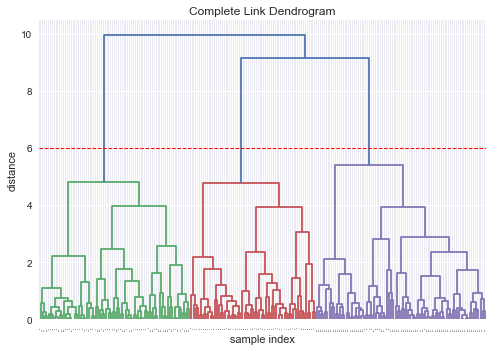

accuracy for Complete Link: 0.28095238095238095
silhouette for Complete Link: 0.44861711466563314


In [12]:
# complete-linkage algorithm全连接算法
Z2 = linkage(X_new, 'complete')
dendrogram(Z2) #树形图
plt.title('Complete Link Dendrogram')
plt.xlabel('sample index') #数字
plt.xticks(size = 2)
plt.ylabel('distance')
plt.axhline(y=6, c='red', lw=1, linestyle='dashed') #划横线聚成3类
# plt.show()

label_predict2 = cut_tree(Z2,n_clusters = 3) #树剪枝(聚三类)，按数据集数据条目顺序的分类标签

silhouette2 = silhouette_score(Origin_data,label_predict2.ravel()) #轮廓系数

label_predict2 = label_predict2.tolist()
for i in range(0,len(label_predict2)):
    label_predict2[i] = label_predict2[i][0]
# print(label_predict2)

# for i in range(0,len(label_predict2)): #聚类标签顺序调换
#     if(label_predict2[i] == 1):
#         label_predict2[i] = 2
#     elif(label_predict2[i] == 2):
#         label_predict2[i] = 1
print(label_predict2)

accuracy2 = accuracy_score(Y,label_predict2) #正确分类的比例
print('accuracy for Complete Link:',accuracy2)
print('silhouette for Complete Link:',silhouette2)

### 3.Average link：基于平均距离

- 合并簇依据：两个集群的元素之间所有对的平均距离最小

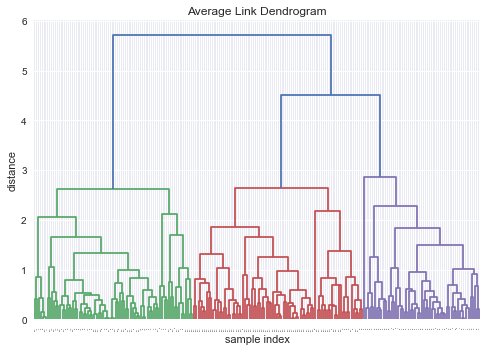

accuracy for Average Link: 0.9285714285714286
silhouette for Average Link: 0.4429885670397505


In [13]:
# average-linkage algorithm均链接算法
Z3 = linkage(X_new, 'average')
dendrogram(Z3)
plt.title('Average Link Dendrogram')
plt.xlabel('sample index') #数字
plt.xticks(size = 2)
plt.ylabel('distance')
plt.show()

label_predict3 = cut_tree(Z3,n_clusters = 3) #树剪枝(聚三类)，按数据集数据条目顺序的分类标签
silhouette3 = silhouette_score(Origin_data,label_predict3.ravel()) #轮廓系数
label_predict3 = label_predict3.tolist()
for i in range(0,len(label_predict3)):
    label_predict3[i] = label_predict3[i][0]
#print(label_predict3)

accuracy3 = accuracy_score(Y,label_predict3) #正确分类的比例
print('accuracy for Average Link:',accuracy3)
print('silhouette for Average Link:',silhouette3)

### 4.Centroid link：基于中心链接

- 合并簇依据：两个簇的中心的距离最小

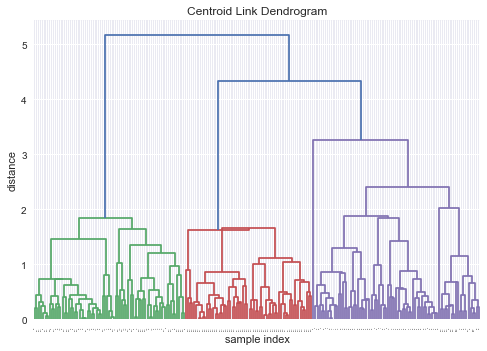

accuracy for Centroid Link: 0.9380952380952381
silhouette for Centroid Link: 0.4245174645552408


In [14]:
# centroid linkage method
Z4 = linkage(X_new, 'centroid')
dendrogram(Z4)
plt.title('Centroid Link Dendrogram')
plt.xlabel('sample index') #数字
plt.xticks(size = 2)
plt.ylabel('distance')
plt.show()

label_predict4 = cut_tree(Z4,n_clusters = 3) #树剪枝(聚三类)，按数据集数据条目顺序的分类标签
silhouette4 = silhouette_score(Origin_data,label_predict4.ravel()) #轮廓系数

label_predict4 = label_predict4.tolist()
for i in range(0,len(label_predict4)):
    label_predict4[i] = label_predict4[i][0]
# print(label_predict)

accuracy4 = accuracy_score(Y,label_predict4) #正确分类的比例
print('accuracy for Centroid Link:',accuracy4)
print('silhouette for Centroid Link:',silhouette4)

## 五、average link策略的聚类效果评估

- 由四得，average link策略和centroid linkage策略的准确度相同，但average link策略的轮廓系数更大。因此average link策略聚类效果最好。

### 1.混淆矩阵

In [15]:
seeds_type = ['Kama', 'Rosa', 'Canadian']
conf_mat = confusion_matrix(label_predict3, Y)
conf_mat = pd.DataFrame(conf_mat, columns=seeds_type, index=seeds_type)
conf_mat = conf_mat.rename_axis('Predicted Labels').rename_axis(
                                'True Labels', axis='columns')
conf_mat

True Labels,Kama,Rosa,Canadian
Predicted Labels,,,
Kama,55,0,0
Rosa,5,70,0
Canadian,10,0,70


### 2.精确度(precision)/召回率(recall)/F1值(f1-score)

其中

- Macro Average
宏平均是指在计算均值时使每个类别具有相同的权重，最后结果是每个类别的指标的算术平均值。

- Micro Average
微平均是指计算多分类指标时赋予所有类别的每个样本相同的权重，将所有样本合在一起计算各个指标。

- Weighted Average
加权平均

In [16]:
report = classification_report(Y, label_predict3, output_dict=True)
report = pd.DataFrame(report)
report.columns = ['Kama', 'Rosa', 'Canadian', 
                  'macro_avg', 'micro_avg', 'weighted_avg']
report

,Kama,Rosa,Canadian,macro_avg,micro_avg,weighted_avg
precision,1.000000,0.933333,0.875000,0.928571,0.936111,0.936111
recall,0.785714,1.000000,1.000000,0.928571,0.928571,0.928571
f1-score,0.880000,0.965517,0.933333,0.928571,0.926284,0.926284
support,70.000000,70.000000,70.000000,0.928571,210.000000,210.000000


### 3.散点图

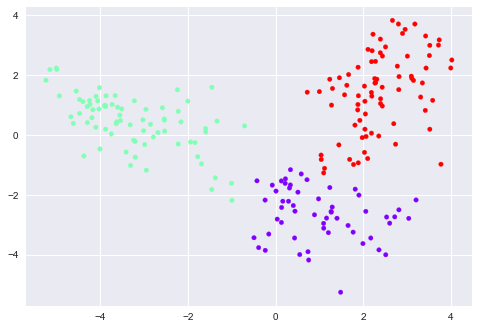

In [17]:
plt.scatter(X_new[:,0],X_new[:,1],c=label_predict3,s=20,cmap='rainbow')

### 4.聚类结果预览（10条）

- type为已知标签列；predict_type为聚类标签类。

In [18]:
Origin_data["predict_type"] = [i+1 for i in label_predict3]
Origin_data.head(10)

,area,perimeter,compactness,kernel_length,kernel_width,assymetry_coeff,groove_length,type,predict_type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,1
5,14.38,14.21,0.8951,5.386,3.312,2.462,4.956,1,1
6,14.69,14.49,0.8799,5.563,3.259,3.586,5.219,1,1
7,14.11,14.10,0.8911,5.420,3.302,2.700,5.000,1,1
8,16.63,15.46,0.8747,6.053,3.465,2.040,5.877,1,2
9,16.44,15.25,0.8880,5.884,3.505,1.969,5.533,1,2


### 5. 按聚类后的3类显示7个维度的关系矩阵

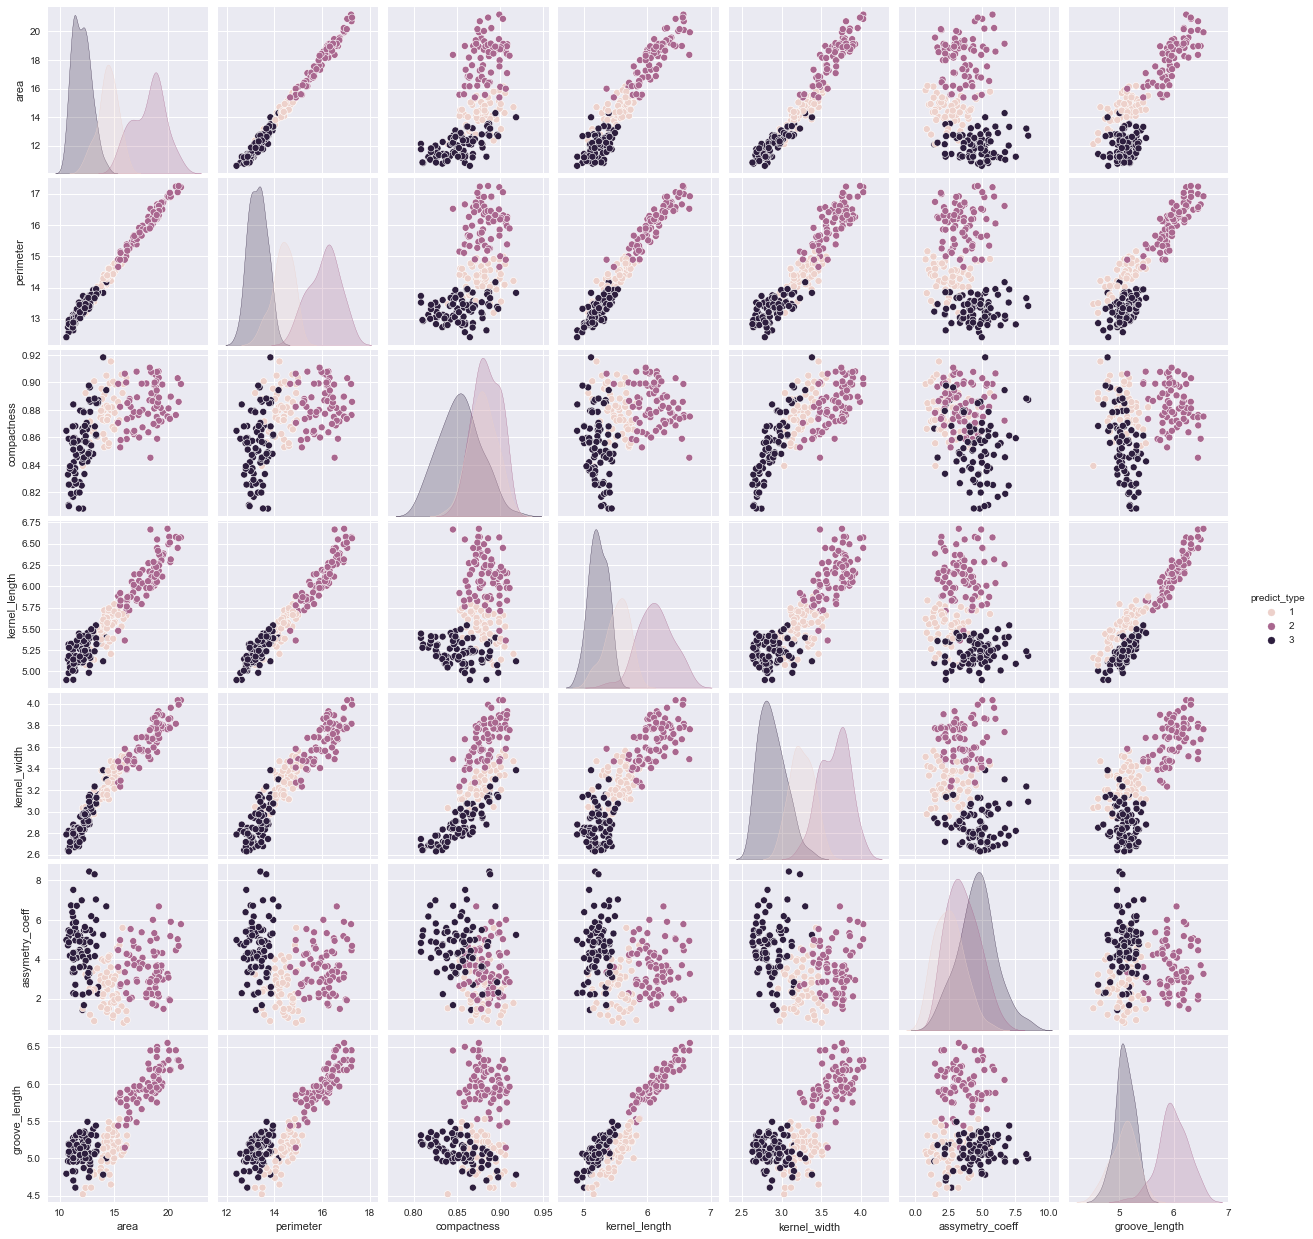

In [19]:
pairplot(data=Origin_data, hue="predict_type", 
         vars=['area', 'perimeter', 'compactness', 'kernel_length',
         'kernel_width', 'assymetry_coeff','groove_length'])